For this data challenge, we are given 6 different text files with 7 columns. The experimental data is taken from a mother machine, a microfluidic device (dead ended channels with a diameter of approximately one micron) used to study the growth dynamics of a single-cell bacteria. The different text files (glucose, glucose_6aa, glucose_12aa, sorbitol, synthetic rich, TSB, and glycerol) are the different nutrients used for the growth of the bacteria in the experiment.

The goal is to find which model can describe the relationship between the following measurements found in the data:

Measurements include:
* s_b_um_ss (sb) - size of cell at birth
* s_d_um_ss (sd) - size of cell at division
* gen_time_min_ss (t) - time it takes for one cell to divide into two
* delta_s_ss ($\Delta s$)- is the added length (s_d_um_ss = s_b_um_ss + $\Delta s$, or the difference between s_d_um_ss and s_b_um_ss)
* elongation rate ($\lambda$)

The following measurements are related using this equation:

(eq1) $ sd = sb * e^{ \lambda t}$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

This notebook is divided into 3 parts:

Part 1: we use only 1 dataset, and check the correlation of the different variables

Part 2: we start playing around with models, and check which model can describe the behavior of the data that we have

Part 3: from the model identified in Part 2, we check if the same relationship holds to the remaining datasets that we have

### Part 1

We begin by looking at one dataset: glucose.txt

In [2]:
glucose_df = pd.read_csv('glucose.txt', sep='\t')
#drop the two columns as these are only identifiers used in the experiment and not relevant to the goal
glucose_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

In [3]:
#use the correct elongation rate by using the eq1
def true_model(df):
    df['new_lambda'] = (np.log(df['s_d_um_ss'] / df['s_b_um_ss'])) / df['gen_time_min_ss']
    df['correct_sd'] = df['s_b_um_ss']*(np.exp(df['new_lambda']* df['gen_time_min_ss']))
    return df

In [4]:
glucose_df = true_model(glucose_df)

In [5]:
#use the correct_elongation_rate (this is the correct one), and not the elongation rate. Now correct_sd and sd matches.
glucose_df.drop(columns=['elongation_rate_ss', 'correct_sd'], inplace=True)

As a starting point, what we did was to check the correlation of the different variables through visualization by using heatmap, and pearson correlation

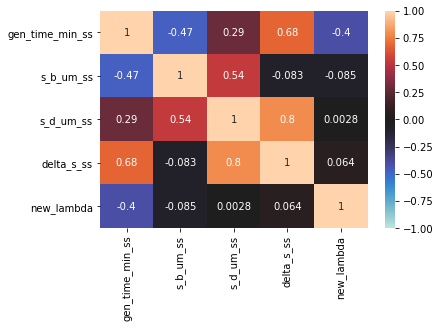

In [6]:
#find correlation between the variables
sns.heatmap(glucose_df.corr(), center = 0, annot = True, vmax = 1, vmin = -1)
plt.show()

In [7]:
print('pearson correlation for sb and sd:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['s_d_um_ss']))
print('pearson correlation for sb and gen time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['gen_time_min_ss']))
print('pearson correlation for sb and delta_s:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['delta_s_ss']))

pearson correlation for sb and sd: (0.5370257372597634, 0.0)
pearson correlation for sb and gen time: (-0.4705035319996662, 0.0)
pearson correlation for sb and delta_s: (-0.0833669118342632, 7.230816906395036e-21)


We found that: 
1. sb and sd are positively correlated
2. sb and gen time (t) are negatively correlated
3. sb and delta_s ($\Delta s$) are not correlated

----

### Part 2

There are three models to explain the cell division rule as found in the [reference](https://www.biorxiv.org/content/10.1101/2020.10.01.322685v1.full.pdf) : timer, sizer, and adder models.
* The timer model tells us that cells divide after a certain time
* The sizer model tells us that cells divide after growing to a certain size
* The adder model tells us that cells divide after a certain amount of cell size is added, regardless of their initial size

The goal is to find which among the three models can describe the data that we have.

#### Timer model

To check the timer model, we randomize the gen time once (t'), and calculated: 

(eq2) sd from random time$ = sb * e ^{ \lambda t'}$ where t' denotes gen time that has been randomized

and

(eq3) $\Delta_s$ from random time = sd from random time - sb

Then we can check the correlations of the following, and see if we still observe the same correlations as above after randomization:
1. sb vs sd from random time
2. sb vs t'
3. sb vs $\Delta_s$ from random time

In [8]:
#randomize gen time
glucose_df['random_time'] = np.random.permutation(glucose_df['gen_time_min_ss'])
#calculate sd after randomizing gen time
glucose_df['sd_from_random_time'] = glucose_df['s_b_um_ss']*(np.exp(glucose_df['new_lambda']* glucose_df['random_time']))

We then check if the three correlations that we found from the data still hold after randomization

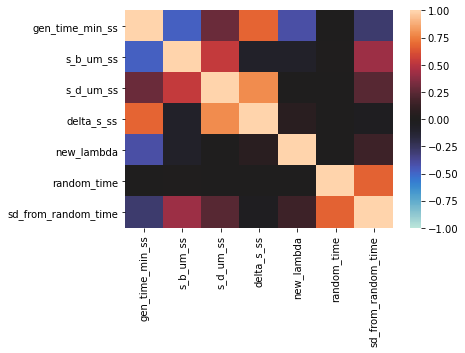

In [9]:
sns.heatmap(glucose_df.corr(), center = 0, vmax = 1, vmin = -1)
plt.show()

In [10]:
print('Correlation 1: sb vs sd')
print('sb vs sd:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['s_d_um_ss']))
print('sb vs sd from random time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['sd_from_random_time']))

print('Correlation 2: sb vs gen time')
print('sb vs gen time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['gen_time_min_ss']))
print('sb vs random time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['random_time']))

print('Correlation 3: sb vs delta_s')
print('sb vs delta_s:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['delta_s_ss']))
print('sb vs delta_s from random time:', pearsonr(glucose_df['s_b_um_ss'], (glucose_df['sd_from_random_time']-glucose_df['s_b_um_ss'])))

Correlation 1: sb vs sd
sb vs sd: (0.5370257372597634, 0.0)
sb vs sd from random time: (0.42352058870346265, 0.0)
Correlation 2: sb vs gen time
sb vs gen time: (-0.4705035319996662, 0.0)
sb vs random time: (0.009547198410873065, 0.28405786522240395)
Correlation 3: sb vs delta_s
sb vs delta_s: (-0.0833669118342632, 7.230816906395036e-21)
sb vs delta_s from random time: (0.22269438752855342, 2.7877386115789333e-141)


We now observe that:
1. sb and sd from random time are still positively correlated
2. sb and random time are not correlated
3. sb and delta_s are now positively correlated

2 and 3 differs from the relationship that we observed from the data. Thus we can say that the timer model is not the correct model that can describe the data.

#### Sizer model

To check the sizer model, we randomize the sb once (sb'), and calculated: 

(eq4) sd from random sb$ = sb' * e ^{ \lambda t}$ where sb' denotes sb that has been randomized

rewriting t from (eq4) we get (eq5):

(eq5) time from random sb = $\frac{1}{\lambda} ln (\frac{sd from random sb}{sb'}) $

and

(eq6) $\Delta_s$ from random sb = sd from random sb - sb'

Then we can check the correlations of the following, and see if we still observe the same correlations from the data after randomization:
1. random sb vs sd from random sb
2. random sb vs time from random sb
3. random sb vs $\Delta_s$ from random sb

In [11]:
#randomize sb
glucose_df['random_sb'] = np.random.permutation(glucose_df['s_b_um_ss'])
#calculate sd after randomizing sb
glucose_df['sd_from_random_sb'] = glucose_df['random_sb']*(np.exp(glucose_df['new_lambda']* glucose_df['gen_time_min_ss']))
#use eqn 5 to get t from randomizing sb
glucose_df['sizer_model_random_time'] = (1/glucose_df['new_lambda'])*(np.log(glucose_df['sd_from_random_sb']/glucose_df['random_sb']))

We then check if the three correlations that we found from the data still hold after randomization

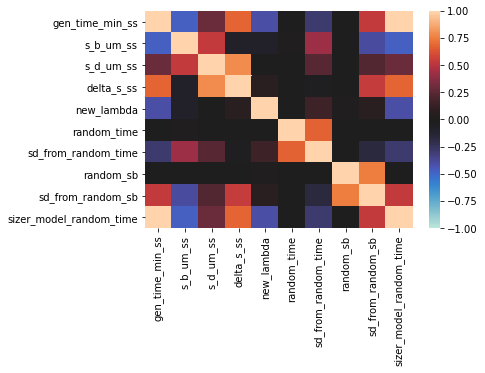

In [12]:
sns.heatmap(glucose_df.corr(), center = 0, vmax = 1, vmin = -1)
plt.show()

In [13]:
print('Correlation 1: sb vs sd')
print('sb vs sd:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['s_d_um_ss']))
print('random sb vs sd from random sb:', pearsonr(glucose_df['random_sb'], glucose_df['sd_from_random_sb']))

print('Correlation 2: sb vs gen time')
print('sb vs gen time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['gen_time_min_ss']))
print('random sb vs time from random sb:', pearsonr(glucose_df['random_sb'], glucose_df['sizer_model_random_time']))

print('Correlation 3: sb vs delta_s')
print('sb vs delta_s:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['delta_s_ss']))
print('random sb vs delta_s from random sb:', pearsonr(glucose_df['random_sb'], (glucose_df['sd_from_random_sb']-glucose_df['s_b_um_ss'])))

Correlation 1: sb vs sd
sb vs sd: (0.5370257372597634, 0.0)
random sb vs sd from random sb: (0.7517308393166979, 0.0)
Correlation 2: sb vs gen time
sb vs gen time: (-0.4705035319996662, 0.0)
random sb vs time from random sb: (-0.008197206154648893, 0.3576950067269975)
Correlation 3: sb vs delta_s
sb vs delta_s: (-0.0833669118342632, 7.230816906395036e-21)
random sb vs delta_s from random sb: (0.6273893044913261, 0.0)


We now observe that:
1. random sb and sd from random sb are still positively correlated
2. random sb and time from random sb are not correlated
3. random sb and delta_s from random sb became positively correlated. 

3 differs from the relationship that we observed from the data. Thus we can say that the sizer model is not the correct model that can describe the data.

#### Adder model

To check the adder model, we randomize the delta_s once ($\Delta_s'$), and calculated: 

(eq7) sd from random $\Delta_s$ = sb + $\Delta_s'$ where $\Delta_s'$ denotes delta_s that has been randomized

and

(eq8) time from random $\Delta_s$ = $\frac{1}{\lambda} ln (\frac{sd from random \Delta_s }{sb}) $


Then we can check the correlations of the following, and see if we still observe the same correlations from the data after randomization:
1. sb vs sd from random $\Delta_s$
2. sb vs time from random $\Delta_s$
3. sb vs $\Delta_s'$

In [14]:
#randomize delta_s
glucose_df['random_delta'] = np.random.permutation(glucose_df['delta_s_ss'])
#calculate sd after randomizing delta
glucose_df['sd_from_random_delta'] = glucose_df['s_b_um_ss']+glucose_df['random_delta']
#calculate time from random delta_s
glucose_df['adder_model_random_time'] = (1/glucose_df['new_lambda'])*(np.log(glucose_df['sd_from_random_delta']/glucose_df['s_b_um_ss']))

We then check if the three correlations that we found from the data still hold after randomization

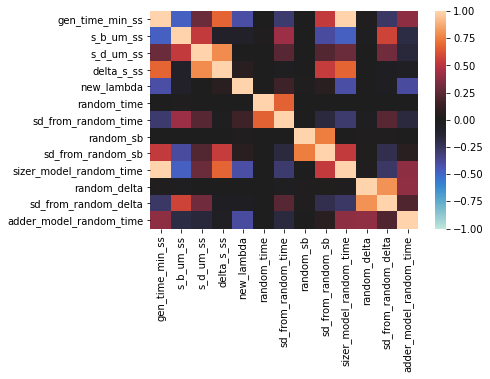

In [15]:
sns.heatmap(glucose_df.corr(), center = 0, vmax = 1, vmin = -1)
plt.show()

In [16]:
print('Correlation 1: sb vs sd')
print('sb vs sd:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['s_d_um_ss']))
print('sb vs sd from random delta:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['sd_from_random_delta']))

print('Correlation 2: sb vs gen time')      
print('sb vs gen time:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['gen_time_min_ss']))
print('sb vs gen time from random delta:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['adder_model_random_time']))

print('Correlation 3: sb vs delta_s')
print('sb vs delta_s:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['delta_s_ss']))
print('sb vs random delta_s:', pearsonr(glucose_df['s_b_um_ss'], glucose_df['random_delta']))

Correlation 1: sb vs sd
sb vs sd: (0.5370257372597634, 0.0)
sb vs sd from random delta: (0.5708492710339457, 0.0)
Correlation 2: sb vs gen time
sb vs gen time: (-0.4705035319996662, 0.0)
sb vs gen time from random delta: (-0.1817972469798667, 5.116157474240136e-94)
Correlation 3: sb vs delta_s
sb vs delta_s: (-0.0833669118342632, 7.230816906395036e-21)
sb vs random delta_s: (-0.022680297898944487, 0.010923910066929431)


We now observe that:
1. sb and randomized sd are positively correlated
2. randomized gen time and sb are negatively correlated
3. randomized delta_s and sb are not correlated

After randomizing, the relationship that we have observed from the original data still holds. So, the adder model is the true model. 

-----------

### Part 3

From Part 2 we found that the Adder model is the true model. So we check the rest of the datasets and see if Adder model holds. We do this by:

1. checking the pearson correlation: as before, checking the correlation from the original data, and after randomizing, if the same relationship holds
2. visualization: plotting the the variables that we are interested in - the original data points and after randomization, and check if visually, the points are not very different from each other 

In [17]:
glucose_df = pd.read_csv('glucose.txt', sep='\t')
glucose_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

glucose_6aa_df = pd.read_csv('glucose_6aa.txt', sep='\t')
glucose_6aa_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

glucose_12aa_df = pd.read_csv('glucose_12aa.txt', sep='\t')
glucose_12aa_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

sorbitol_df = pd.read_csv('sorbitol.txt', sep='\t')
sorbitol_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

synthetic_rich_df = pd.read_csv('synthetic_rich.txt', sep='\t')
synthetic_rich_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

TSB_df = pd.read_csv('TSB.txt', sep='\t')
TSB_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

glycerol_df = pd.read_csv('glycerol.txt', sep='\t')
glycerol_df.drop(columns = ['FOV_ID_ss', 'channel_ID_ss'], inplace=True)

In [18]:
#compute the relevant quantities to use the Adder model
def compute_quantities(df):
    df['new_lambda'] = (np.log(df['s_d_um_ss'] / df['s_b_um_ss'])) / df['gen_time_min_ss']
    df['random_delta'] = np.random.permutation(df['delta_s_ss'])
    df['sd_from_random_delta'] = df['s_b_um_ss']+df['random_delta']
    df['adder_model_random_time'] = (1/df['new_lambda'])*(np.log(df['sd_from_random_delta']/df['s_b_um_ss']))
    df = df.replace([np.inf, -np.inf], np.nan)
    return df.dropna()

glucose_df_new = compute_quantities(glucose_df)
glucose_6aa_df_new = compute_quantities(glucose_6aa_df)
glucose_12aa_df_new = compute_quantities(glucose_12aa_df)
sorbitol_df_new = compute_quantities(sorbitol_df)
synthetic_rich_df_new = compute_quantities(synthetic_rich_df)
TSB_df_new = compute_quantities(TSB_df)
glycerol_df_new = compute_quantities(glycerol_df)

#### sb vs sd

glucose_df
sb vs sd: (0.5370257372597634, 0.0)
sb vs sd from random delta_s: (0.5716752979380952, 0.0)


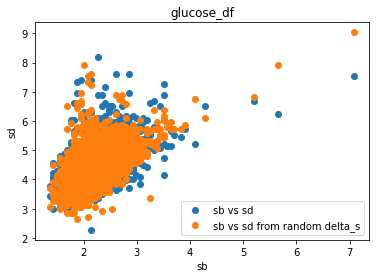

glucose_6aa_df
sb vs sd: (0.500039113080262, 0.0)
sb vs sd from random delta_s: (0.5573378266723465, 0.0)


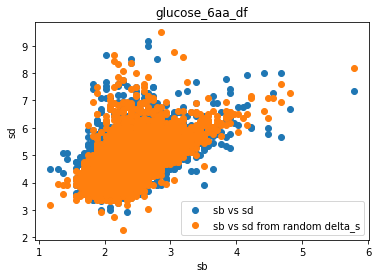

glucose_12aa_df
sb vs sd: (0.5714779676987086, 0.0)
sb vs sd from random delta_s: (0.5693422443974138, 0.0)


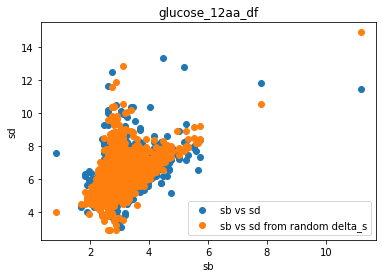

sorbitol_df
sb vs sd: (0.5764243634025024, 0.0)
sb vs sd from random delta_s: (0.6145267274317672, 0.0)


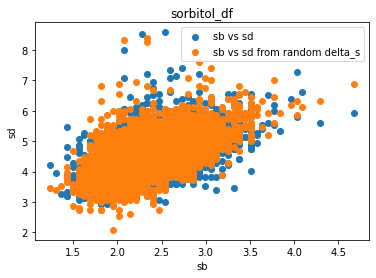

synthetic_rich_df
sb vs sd: (0.48468126982839177, 0.0)
sb vs sd from random delta_s: (0.5221566447596476, 0.0)


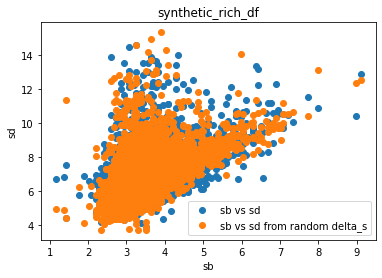

TSB_df
sb vs sd: (0.5767402498497021, 0.0)
sb vs sd from random delta_s: (0.5422755912820035, 0.0)


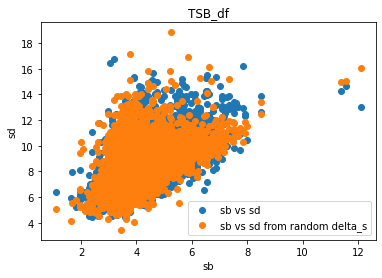

glycerol_df
sb vs sd: (0.5129106679166298, 0.0)
sb vs sd from random delta_s: (0.6086249380317139, 0.0)


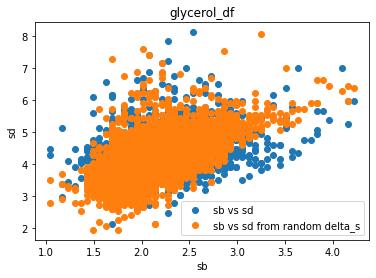

In [19]:
list_df = [glucose_df_new, glucose_6aa_df_new, glucose_12aa_df_new, sorbitol_df_new, synthetic_rich_df_new, TSB_df_new, glycerol_df_new]
title_list = ['glucose_df', 'glucose_6aa_df', 'glucose_12aa_df', 'sorbitol_df', 'synthetic_rich_df', 'TSB_df', 'glycerol_df']
for i, j in zip(list_df, title_list):
    title = '{}'.format(j)
    print(title)
    print('sb vs sd:', pearsonr(i['s_b_um_ss'], i['s_d_um_ss']))
    print('sb vs sd from random delta_s:', pearsonr(i['s_b_um_ss'], i['sd_from_random_delta']))
    
    plt.scatter(i['s_b_um_ss'], i['s_d_um_ss'], label='sb vs sd')
    plt.scatter(i['s_b_um_ss'], i['sd_from_random_delta'], label='sb vs sd from random delta_s')
    
    title_ = '{}'.format(j)
    plt.title(title_)
    plt.xlabel('sb')
    plt.ylabel('sd')
    plt.legend()
    plt.show()

#### sb vs gen time

glucose_df
sb vs gen time: (-0.4705035319996662, 0.0)
sb vs gen time from random delta: (-0.18708188477515336, 1.5115489080592117e-99)


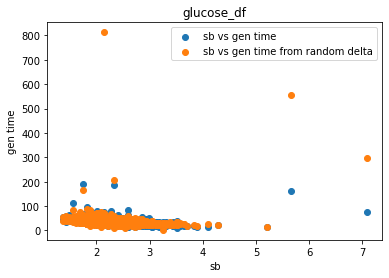

glucose_6aa_df
sb vs gen time: (-0.5198709204378292, 0.0)
sb vs gen time from random delta: (-0.43696137837375804, 0.0)


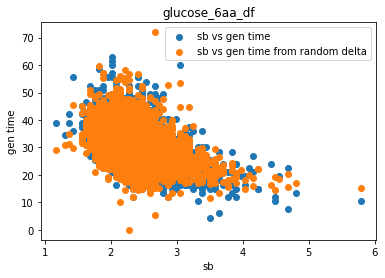

glucose_12aa_df
sb vs gen time: (-0.5170404771010348, 0.0)
sb vs gen time from random delta: (-0.48888754922326705, 0.0)


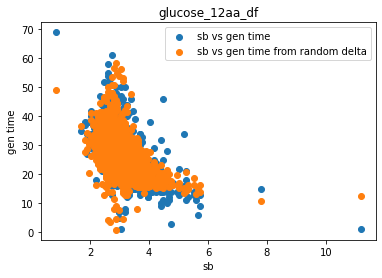

sorbitol_df
sb vs gen time: (-0.5197992934892294, 0.0)
sb vs gen time from random delta: (-0.3901370663911496, 3.775718621558665e-269)


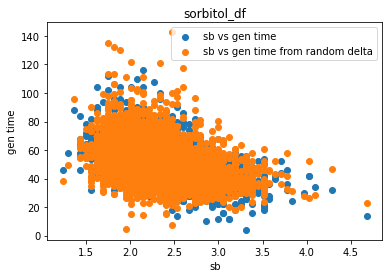

synthetic_rich_df
sb vs gen time: (-0.5040265436568641, 0.0)
sb vs gen time from random delta: (-0.42736852535182834, 0.0)


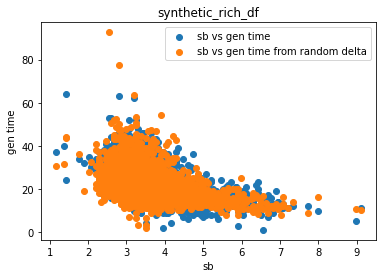

TSB_df
sb vs gen time: (-0.5167330622642264, 0.0)
sb vs gen time from random delta: (-0.4933867812074887, 0.0)


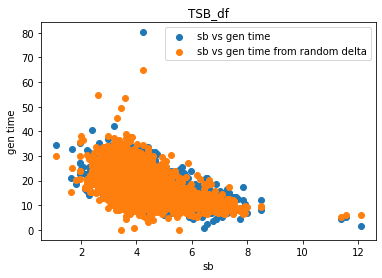

glycerol_df
sb vs gen time: (-0.4746823415361372, 0.0)
sb vs gen time from random delta: (-0.29088488000355606, 1.1267681272347963e-218)


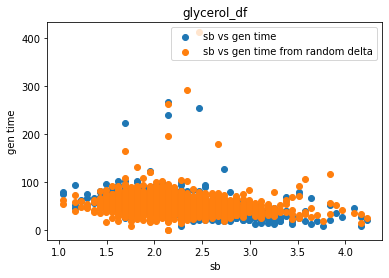

In [20]:
list_df = [glucose_df_new, glucose_6aa_df_new, glucose_12aa_df_new, sorbitol_df_new, synthetic_rich_df_new, TSB_df_new, glycerol_df_new]
title_list = ['glucose_df', 'glucose_6aa_df', 'glucose_12aa_df', 'sorbitol_df', 'synthetic_rich_df', 'TSB_df', 'glycerol_df']
for i, j in zip(list_df, title_list):

    title = '{}'.format(j)
    print(title)
    print('sb vs gen time:', pearsonr(i['s_b_um_ss'], i['gen_time_min_ss']))
    print('sb vs gen time from random delta:', pearsonr(i['s_b_um_ss'], i['adder_model_random_time']))

    
    plt.scatter(i['s_b_um_ss'], i['gen_time_min_ss'], label='sb vs gen time')
    plt.scatter(i['s_b_um_ss'], i['adder_model_random_time'], label='sb vs gen time from random delta')
    
    title_ = '{}'.format(j)
    plt.title(title_)
    plt.xlabel('sb')
    plt.ylabel('gen time')
    plt.legend()
    plt.show()

#### sb vs delta_s

glucose_df
sb vs delta_s: (-0.0833669118342632, 7.230816906395036e-21)
sb vs random delta_s: (-0.021163567393023074, 0.01755463395033981)


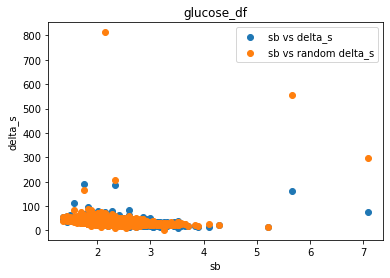

glucose_6aa_df
sb vs delta_s: (-0.09605225382390169, 8.157663800917981e-36)
sb vs random delta_s: (0.0011347482321739512, 0.8829357529342295)


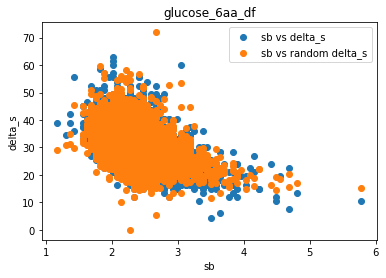

glucose_12aa_df
sb vs delta_s: (0.0009604233986317337, 0.9117708469497094)
sb vs random delta_s: (-0.0028964606231786194, 0.7382522873087888)


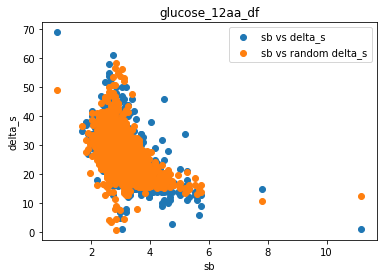

sorbitol_df
sb vs delta_s: (-0.08667342306561099, 6.8662139997567e-14)
sb vs random delta_s: (-0.010499058194707344, 0.365117843402578)


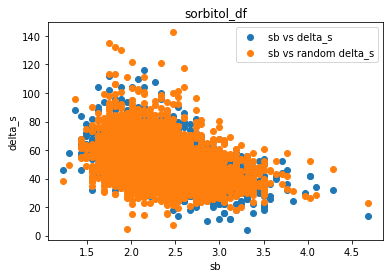

synthetic_rich_df
sb vs delta_s: (-0.06961165256905566, 3.321696484443813e-13)
sb vs random delta_s: (-0.010166947375549516, 0.28819193433566603)


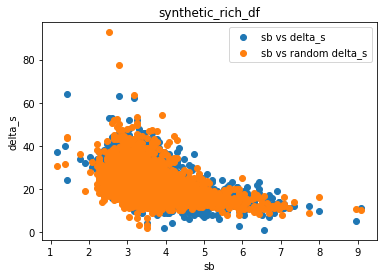

TSB_df
sb vs delta_s: (0.04563049195589356, 1.497262903216218e-06)
sb vs random delta_s: (-0.013507629567284976, 0.1545441283925349)


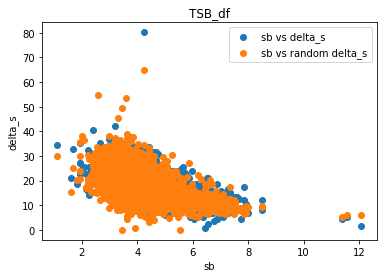

glycerol_df
sb vs delta_s: (-0.17328079848492234, 1.0678599587025694e-76)
sb vs random delta_s: (0.007107308217969586, 0.45054517211890505)


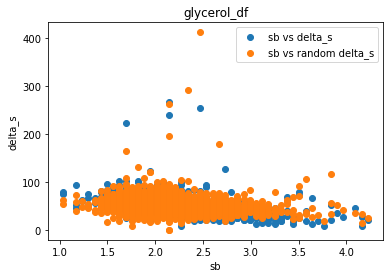

In [21]:
list_df = [glucose_df_new, glucose_6aa_df_new, glucose_12aa_df_new, sorbitol_df_new, synthetic_rich_df_new, TSB_df_new, glycerol_df_new]
title_list = ['glucose_df', 'glucose_6aa_df', 'glucose_12aa_df', 'sorbitol_df', 'synthetic_rich_df', 'TSB_df', 'glycerol_df']
for i, j in zip(list_df, title_list):
    title = '{}'.format(j)
    print(title)
    print('sb vs delta_s:', pearsonr(i['s_b_um_ss'], i['delta_s_ss']))
    print('sb vs random delta_s:', pearsonr(i['s_b_um_ss'], i['random_delta']))

    
    plt.scatter(i['s_b_um_ss'], i['gen_time_min_ss'], label='sb vs delta_s')
    plt.scatter(i['s_b_um_ss'], i['adder_model_random_time'], label='sb vs random delta_s')
    
    title_ = '{}'.format(j)
    plt.title(title_)
    plt.xlabel('sb')
    plt.ylabel('delta_s')
    plt.legend()
    plt.show()

For all the different datasets we found that, 
1. sb and sd from random delta_s  are positively correlated
2. sb and gen time from random delta are negatively correlated
3. sb and random delta_s are not correlated

using pearson correlation and visualization. By visualization, we check how close the true and randomized data points are. 

These agree with the relationships that we observed before randomization:
1. sb and sd are positively correlated
2. sb and gen time (t) are negatively correlated
3. sb and delta_s ($\Delta s$) are not correlated

Thus the adder model is the correct model.